In [21]:
import os
import subprocess
import numpy as np
import pandas as pd
from scipy import stats 
import warnings
import math
#import seaborn as sns
import statsmodels.api as sm
import re
from sklearn.metrics import r2_score
from sklearn.pipeline import Pipeline
#from colorsetup import colors, palette
import matplotlib.pyplot as plt
from pathlib import Path

# Must set to this to path for your system
# Assumes there is a experiment_name directory at this path with subdirectory raw_data and output
# (If you are running on the data included in the repo, the substructure should be fine)
BASE_DIR = Path('/TODO/INSERT/PATH/TO/REPO/ROOT')

# Sanity check your specified path
assert BASE_DIR.is_dir(), "You need to set BASE_DIR to the path to this repository; the specified path does not exist or is not a directory."

os.chdir(BASE_DIR / 'DataAnalysisScripts' / 'ITLAgent-LogProcessingScripts')



AssertionError: You need to set BASE_DIR to the path to this repository; the specified path does not exist or is not a directory.

In [18]:
# Experiment specific variables
# experiment_name = "GroceryTask"
experiment_name = "OfficeTask"
# tidy-kitchen
# experiment_name = "TidyKitchenTask"
#condition_names = ["Planning", "Instruction", "Plan+LLM", "Inst+LLM", "Combined_d2", "Combined_d4"]
#condition_names = ["Instruction", "Inst+Search", "Search+LLM", "Instruction+LLM", "Inst+Search_2+LLM", "Inst+Search_4+LLM"]
#condition_names = ["lm_search4_7Feb", "lm_search4_14Feb", "lm_human_search4_14Feb", "lm_search4_tree_27Feb", "lm_search4_tree_select_27Feb", "lm_search_tree_select_prob_7Mar", "lm_human_search_tree_select_prob_7Mar", "lm_tree_repair_select_13Apr"]

# REW: These should be changed to better "human readable" labels for publication version but these are ok for now
#condition_names = ["lm_human","lm_human_tree","lm_human_tree_select","lm_human_tree_eval","lm_human_tree_eval_select","lm","lm_tree","lm_tree_select","lm_tree_eval","lm_tree_eval_select"]
#condition_names = ["lm_human", "Rlm_tree_eval_select_run1", "Rlm_tree_eval_select_run2", "Rlm_tree_eval_select_run3","Rlm_tree_eval_select_run4", "Rlm_tree_eval_select_run5"]
#condition_names = ["lm_human","lm_human_tree_eval_select","lm","lm_tree","lm_tree_select","lm_tree_eval","lm_tree_eval_select"]

condition_names = ["TBP","TBP+O","ST","STS","STAR","STARS","STARS+O"]
#condition_names = ["run1", "run2", "run3", "run4", "run5", "run6", "run7","run8", "run9", "run10"]
condition_names.reverse()
print("Number of conditions:", len(condition_names))


# file names we process
dialog_file = "dialog.txt"
search_file = "final-search-states.txt"
final_world = "final-world.txt"
token_file = "tokens.txt"

# Note that this is also referenced in compute_task_completion_rate() below. Probably should be a global.
if experiment_name in ("GroceryTask", "OfficeTask"):
    gold_solutions = "gold.txt"
elif experiment_name == "TidyKitchenTask":
    gold_solutions =  "gold-standard-canonical.txt"
else:
    raise ValueError("Unknown experiment name: " + experiment_name) 
# gold_solutions =  "gold-standard-atypical.txt"

# Note that the data files are organized with the experiment at the root and sbudirectories for data and files below
output_directory =  "./" + experiment_name + "/output/"
data_path = "./" + experiment_name + "/raw_data/" 
goldpath = "./" + experiment_name + "/" + gold_solutions

if not Path(experiment_name).is_dir():
    raise ValueError(f"Experiment directory does not exist: {experiment_name}")
Path(output_directory).mkdir(exist_ok=True)
if not Path(data_path).is_dir():
    raise ValueError(f"Experiment raw data directory does not exist: {data_path}")
if not Path(goldpath).is_file():
    raise ValueError(f"Gold standard file does not exist: {goldpath}")


Number of conditions: 7


In [678]:
# Simple helper function that will be used for the number of retrieved goals
def count_lines(filename):
    result = subprocess.run(['wc', '-l', filename], capture_output=True, text=True)
    output = result.stdout.strip().split()
    line_count = int(output[0])
    return line_count


# Determine various statistics for the LLM conditions
#
# Two types of queries: goal (request for a goal) or action
# Four types of categorizatio of the responses
#    Number of goals from the LM that are actually used by the agent or “sourced” (can count “LM sourced goal” in log but subtract “Auto verifying LM sourced goal”)
#    Number of goals proposed to be used (asks human question) or “proposed” (easiest to count in dialog)
#    Number of goal responses retrieved by the agent or “retrieved” (some are never asked about or sourced) (hard to count automatically in cic.log)
#    Number of queries made to the LM, which accounts for duplicate LM response or “queries” (would need other data to count this, I have it for a few conditions)
#
# For IJCAI23, this script uses the cic.log and dialogue.txt files only, meaning that 
#         Number of retrievals NOT CALCULATED
#         Number of queries    NOT CALCULATED
#
# For CORL23, this script adds the number of goal retrievals. This script assumes that the number of 
#    lines in retrieved.txt is the number of goal retrievals (JK provided this input but not clear if 
#    retrieval.txt always/only includes goal retrievals; eg, CORL experiments did not use actions)

def compute_LLM_response_statistics(condition):

    # Init the files that we need
    log_filepath = data_path + condition + "/cic.log"
    dialog_filepath = data_path + condition + "/dialog.txt"
    retrieved_goal_filepath = data_path + condition + "/retrieved.txt"

    rel_data = pd.read_csv(goldpath, header=None)
    relationships = rel_data.values.tolist()

    propose_action_string ="should I"
    propose_goal_string ="is the goal is"

    # Set all the counters to 0
    goal_count = action_count = propose_goals = propose_actions = 0

   
    
    # Count the number of goals/actions "sourced" (actually used) by the agent
    with open(log_filepath, 'r') as logfile:
        for line in logfile:
#        if line.startswith('         ^complete-sentence'):
#            print(line)
#        if line.startswith('         ^if-sentence'):
#            print(line)
#        if line.startswith('         ^metadata'):
#            print(line)
            if line.startswith('LM sourced goal'):
                # print(line)
                goal_count += 1
            elif line.startswith('LM sourced action'):
                action_count += 1
                
    # Count the number of goals/action "proposed" by the LLM 
    # (As above, this number does not include all retrievals)
    with open(dialog_filepath, "r") as dialog_file:
        for line in dialog_file:
            if line.startswith("Rosie: [LM]"):
                if propose_action_string in line:
                    propose_actions += 1
                elif propose_goal_string in line:
                    propose_goals += 1
                else:
                    print("Issue: Saw start string but not recognizing action or goal on this line:", line)

                    
    retrieved_goals = count_lines(retrieved_goal_filepath)
    
    # Capture token data
    token_data = pd.read_csv(filepath+'/tokens.txt', sep=';')
                    
    LLM_retrieval_counts = { "proposed goals": propose_goals,
                             "proposed actions": propose_actions,
                             "sourced goals": goal_count,
                             "sourced actions": action_count,
                             "retrieved goals": retrieved_goals,
                             "prompt tokens": token_data['prompt tokens'].sum(),
                             "completion tokens": token_data['completion tokens'].sum(),
                             "total tokens":token_data['total tokens'].sum()}
            
    #print("\n", condition)
    #print("     proposed goals: ", propose_goals, "proposed actions: ", propose_actions)
    #print("     sourced  goals: " , goal_count, " sourced actions: ", action_count)

    return LLM_retrieval_counts


In [679]:
def compute_task_completion_rate(condition):

    #goldpath = "./" + experiment_name + "/gold-standard-canonical.txt"
    filepath = data_path + condition + "/final-world.txt"
    separator = ")"
    
    # Regular expressions for extracting ID/atttribute/values from WME printouts
    wme_pattern = re.compile(r'\(([A-Z][0-9]+)( \^[a-z-]+ [A-z0-9-.|]+\b)+\)')
    wme_pattern = re.compile(r'\(([A-Z][0-9]+)( \^[A-z0-9-]+ [A-z0-9-.|]+\b)+\)')
    arg_val_pattern = re.compile(r'\([A-Z][0-9]+ (.)+\)') 
    
    # Init task completion rate to zero
    task_completion_rate = near_misses = 0.0
    
    WME_columns = ['ID', 'Attribute', 'Value']
    WMEs = pd.DataFrame(columns=WME_columns)

    with open(filepath) as file:
        text = file.read()

    # Remove all the extra embedded spaces
    text = ' '.join(text.split())
    # Regex does not like the pipe so just removing it from the text
    text = text.replace("|","")

    # Split on the separator
    wme_list = text.split(separator)
    # Remove unwanted extra line
    wme_list.pop()
    #print(wme_list)

    # Strip out all the new lines
    wme_list = [line.strip() for line in wme_list]
    wme_list = [' '.join(line.splitlines()) for line in wme_list]

    # Add the ending paren back to ea item
    wme_list = [line + separator for line in wme_list]

    for line in wme_list:
        #print("Line: ",line)
        # Extract the ID
        line_match = wme_pattern.match(line)
                     
        if (line_match is None):
            print("Expression mismatch error")
            break
        else:
            ID = line_match[1]
            #print("ID: ", ID)
            line = line.replace("^","")
            line = line.replace(")","")
            sline = line.split()
            # remove the ID
            sline.pop(0)
        
            att_vals = zip(sline[0::2], sline[1::2])
 
            for att_val in att_vals:
                att, val = att_val
                WMEs.loc[len(WMEs.index)] = [ID, att, val]

    properties = ["is-open1","is-activated1"]
    predicates = ["in", "on"]

    
    equivalent_relationships = {"sink1": "dishwasher1",
                                "dishwasher1": "sink1"}
    
    
    near_miss_relationships = {"garbage1": "bin1",
                                "bin1": "garbage1",
                                "cupboard1": "pantry1",
                                "pantry1": "cupboard1"}

# Commenting out the relationships as defined in the AAAI data analysis
#   Note that these data depended on the root-category in the relationship[0] position and 
#   for the IJCAI data analysis we have switched to using handle for this value in the predicate
#     relationships =  [["fridge1", "is-open1", "not-open1"],
#                   ["dishwasher1", "is-open1", "not-open1"],
#                   ["cupboard1", "is-open1", "not-open1"],                  
#                   ["bottle1", "in", "bin1"],
#                   ["can1", "in", "bin1"],
#                   ["cup1", "in", "garbage1"],
#                   ["fork1", "in", "dishwasher1"],                  
#                   ["glass1", "in", "cupboard1"],                  
#                   ["juice1", "in", "fridge1"],
#                   ["ketchup1", "in", "fridge1"],                  
#                   ["milk1", "in", "fridge1"],
#                   ["mug1", "in", "sink1"],                  
#                   ["napkin1", "in", "garbage1"],
#                   ["plate1", "in", "cupboard1"],                  
#                   ["soda1", "in", "bin1"]
#                  ]

    
    rel_data = pd.read_csv(goldpath,header=None)
    relationships = rel_data.values.tolist()

    # Find some important IDs in the dataset

    # MAINTAINER NOTE:
    # The scripts are brittle to the root WME, which can change from one experiment to another. 
    # Essentially, if you get an error that looks something like this: 
    # Cell In[15], line 115, in compute_task_completion_rate(condition)
    # 	111 # Root ID for April (simulator)
    # 	112 # RootID for the Grocery Task (Aug 2023)
    # 	113 RootID = "W5"
    # --> 115 PredicateRootID = WMEs.loc[(WMEs.ID == RootID) & (WMEs.Attribute == "predicates")].Value.item() 
    # 	116 InID = WMEs.loc[(WMEs.Attribute == "handle") & (WMEs.Value == "in1")].ID.item() 
    # 	117 OnID = WMEs.loc[(WMEs.Attribute == "handle") & (WMEs.Value == "on1")].ID.item() 

    # File /Library/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/pandas/core/base.py:331, in IndexOpsMixin.item(self)
    # 	329 if len(self) == 1:
    # 	330     return next(iter(self))
    # --> 331 raise ValueError("can only convert an array of size 1 to a Python scalar")

    # Look in the ?experiment/?condition/final-world.txt file and set the RootID (in 
    # compute_task_completion_rate()) to whatever the root WME (^world) id is. When we use April, 
    # it's usually W4, but when using internal simulation, it bounces around a bit. (It was a hack to 
    # manually encode this but it usually doesn't change once we set up an experiment, so I have never 
    # made it more general).

    # world.predicates
    
    # W21 for Aug 23 version
    RootID = "W21" 
    
    #W5 for internal simulation
    RootID ="W5"
    
    # Root ID for April (simulator)
    # RootID for the Grocery Task (Aug 2023)
    RootID = "W4"
    
    PredicateRootID = WMEs.loc[(WMEs.ID == RootID) & (WMEs.Attribute == "predicates")].Value.item() 
    InID = WMEs.loc[(WMEs.Attribute == "handle") & (WMEs.Value == "in1")].ID.item() 
    OnID = WMEs.loc[(WMEs.Attribute == "handle") & (WMEs.Value == "on1")].ID.item() 
    #print(InID)
    #print(OnID)
    
    # Initialize counters for computing task relationships
    total_relations = len(relationships)
    #print("Total number of relationships defined in the gold standard: ", total_relations)
    successful_completions = 0
      
    for relationship in relationships:

        # print(relationship)
        if (relationship[1] in properties):    
        
            # Find the fridge
            ObjID = WMEs.loc[(WMEs.Attribute == "handle") & (WMEs.Value == relationship[0])].ID.item()
            #print(ObjID)
            PredID = WMEs.loc[(WMEs.ID == ObjID) & (WMEs.Attribute == "predicates")].Value.item()
            #print(PredID)                                           
            Relation = WMEs.loc[(WMEs.ID == PredID) & (WMEs.Attribute == relationship[1])].Value.item()
            #print(Relation)
            if (Relation == relationship[2]):
                #print("CONFIRMED: Relation ", relationship[1], "confirmed as ", relationship[2], "for object", relationship[0])
                successful_completions += 1
            else:
                print("MISMATCH: Relation ", relationship[1], "was ", Relation, "not ", relationship[2], "for object", relationship[0]) 
        else: 
            Obj1ID = WMEs.loc[(WMEs.Attribute == "handle") & (WMEs.Value == relationship[0])].ID.item()
            Obj2ID = WMEs.loc[(WMEs.Attribute == "root-category") & (WMEs.Value == relationship[2])].ID.item()
                      
            # These are not necessarily unique
            Pred1 = WMEs.loc[(WMEs.Attribute == "1") & (WMEs.Value == Obj1ID)]
            Pred2 = WMEs.loc[(WMEs.Attribute == "2") & (WMEs.Value == Obj2ID)]
        
            if (Pred1.ID.isin(Pred2.ID).any()):
                #print("CONFIRMED:", relationship[0], "is", relationship[1], " ", relationship[2])
                successful_completions += 1
            else:
                # Special processing for equivalent relationships
                
                # If relationship 2 has an equivalent relationship (meaning it is a key in the dict)
                if relationship[2] in equivalent_relationships:
                    Obj2ID = WMEs.loc[(WMEs.Attribute == "root-category") & (WMEs.Value == equivalent_relationships[relationship[2]])].ID.item()
                    Pred2 = Pred2 = WMEs.loc[(WMEs.Attribute == "2") & (WMEs.Value == Obj2ID)]
                    
                    if (Pred1.ID.isin(Pred2.ID).any()):
                       # print("CONFIRMED:", relationship[0], "is", relationship[1], " ", relationship[2])
                       successful_completions += 1 
                    else:
                       print("MISMATCH: No Relation ", relationship[1], "found between ", relationship[0], " and ", relationship[2], " or ", equivalent_relationships[relationship[2]])     
                        
                else: 
            
                    print("MISMATCH: No Relation ", relationship[1], "found between ", relationship[0], " and ", relationship[2])     
    
                    
                    # Check for near-misses
                    # Near-miss is a reasonable location that is not situationally relevant for this kitchen (ie, not the gold)
                    # Example: paper cup is reasonable to recycle in some situations
            
                    if relationship[2] in near_miss_relationships:
                        Obj2ID = WMEs.loc[(WMEs.Attribute == "root-category") & (WMEs.Value == near_miss_relationships[relationship[2]])].ID.item()
                        Pred2 = WMEs.loc[(WMEs.Attribute == "2") & (WMEs.Value == Obj2ID)]
                    
                        if (Pred1.ID.isin(Pred2.ID).any()):
                           # print("NEAR MISS:", relationship[0], "is", relationship[1], " ", near_miss_relationships[relationship[2]])
                           near_misses += 1 
                        else:
                           print("NOT A NEAR MISS: No Relation ", relationship[1], "found between ", relationship[0], " and ", near_miss_relationships[relationship[2]])     
                    
                    #if if_near_miss(relationship,)
                    #print(Pred1.head())
                    #print(Pred2.head())
            
    
    print("Near misses:", near_misses, "Near miss rate:", float(near_misses/total_relations))
    task_completion_rate = float(successful_completions/total_relations)
    
    return task_completion_rate, total_relations

In [680]:
def print_summary_statistics(condition,diadf,seadf,task_completion_rate,total_relations):
    
    debug_statements = False
    
    diadf['speaker'] = diadf['speaker'].replace(['Rosie','Instructor'],['Agent','Human'])
    agent_data = diadf[diadf.speaker == "Agent"]
    human_data = diadf[diadf.speaker == "Human"]
        
    #### Process human/instructor statements: ####
    words = simple_words = num_human_statements = goal_instructions = action_instructions = 0
    
    num_human_statements = len(human_data)
    if (debug_statements): print("Human assertions/instructions:", num_human_statements)

    you_are_done = len(human_data[human_data.statement==" You are done."])
    if (debug_statements): print("Number of human task completion statements", you_are_done)
    repeat = len(human_data[human_data.statement==" Repeat."])
    if (debug_statements): print("Number of human repeat statements: ", repeat)

    goal_instructions = human_data.statement.str.contains("goal").sum() + human_data.statement.str.contains("Repeat the following tasks").sum()
    if (debug_statements): print("Number of Human goal instructions: ", goal_instructions)

    # 1 because first statement is always, by definition, specifying the higher level task name
    initiate_task_subtask_definition = 1 + human_data.statement.str.contains("an object that is").sum()
    if (debug_statements): print("Number of human Task Definition statements: ", initiate_task_subtask_definition)

    human_data['wordcount'] = human_data['statement'].str.split().str.len()
    words = human_data['wordcount'].sum()

    from collections import Counter
    results = Counter()
    human_data['statement'].str.lower().str.split().apply(results.update)
    #print("Results:", results)
    #print("Human data.statement", human_data.statement)
    simple_words = results["yes."] + results["no."]
    if (debug_statements): print("Simple:", simple_words)
    if (simple_words > 0):
        relevancy = results["yes."]/simple_words
    else:
        if (condition == "Search+LLM"):
            # Must hand count relevant responses (see last cell)
            relevancy = 16/30
        else:
            relevancy = 0.

    action_instructions = num_human_statements - goal_instructions - you_are_done - simple_words - initiate_task_subtask_definition - repeat
    if (action_instructions < 0):
            if (debug_statements): print("Possible issue with action instructions, value < 0", action_instructions)
            action_instructions = 0
    if (debug_statements): print("Number of human action statements: ", action_instructions)

    
    #### Process agent queries to instructor ####
    
    # Why was there a -2 rather than -1 in the AAAI script?
    # -1 removes counting the "Im ready for a new task" statement
    agent_queries = len(agent_data)
    if (debug_statements): print("Number of agent queries to instructor:", agent_queries)

    next_goal_or_subtask = agent_data.statement.str.contains(" What is the next goal or subtask of").sum()
    if (debug_statements): print("Number of Next goal Task Queries", next_goal_or_subtask)

        
    # Because we are reporting on the count of subtasks, we are counting all instances of 
    # "next goal of tidy kitchen" here.  
    next_goal_tidy = len(agent_data[agent_data.statement==" What is the next goal or subtask of tidy?"])
    if (debug_statements): print("Redundant Tidy Goals:", next_goal_tidy) 

    # For non-HITL conditions, agent_subtasks will be zero based on this definition     
    agent_subtasks = next_goal_or_subtask - next_goal_tidy - repeat
    if (debug_statements): print("Agent tasks/subtasks:", agent_subtasks)   
    
    search_states = seadf['states'].sum()
    #print(search_states)
    
    print("************************************************")
    print("Experiment: ", experiment_name)
    print("Condition: ", condition)
    print("Number of tidy subtasks:", total_relations)
    print("  Aggregate summary:")
    print("     Tasks completed: ", int(task_completion_rate*total_relations))
    print("     Total number of agent queries to instructor: ", agent_queries)
    print("     Total number of instructor statements", num_human_statements)
    print("        Total number of goal statements",goal_instructions)
    print("        Total number of action statements",action_instructions)
    print("        Total number of yes/no instructions: ", simple_words)
    print("     Total number of instructor words: ", words)
    print("     Total number of search states explored: ", search_states)
    print("     % relevant LLM responses (LLM conditions only): ", relevancy)
    print("  Average/task summary:")
    print("     Task completion rate (%): ", task_completion_rate*100)
    if agent_subtasks > 0:
        print("     Average agent queries to instructor: {:.3f}".format(agent_queries/agent_subtasks))
        print("     Average number of instructor statements {:.3f}".format(num_human_statements/agent_subtasks))
        print("        Average number of goal statements/subtask {:.3f}".format(goal_instructions/agent_subtasks))
        print("        Average number of action statements/subtask {:.3f}".format(action_instructions/agent_subtasks))
        print("        Average number of yes/no instructions/subtask {:.3f}".format(simple_words/agent_subtasks))
        print("     Average number of instructor words/subtask: {:.3f}".format(words/agent_subtasks))
        print("     Average number of search states explored/subtask: {:.3f}".format(search_states/agent_subtasks))
    print("************************************************")
    
    results = {'condition': [condition],
               'queries':[agent_queries],
               'states': [search_states],
               'instructions':[num_human_statements],
               'goal_instructions': [goal_instructions],
               'action_instructions': [action_instructions],
               'yes/no_instructions': [simple_words],
               'instructor_words': [words],
               'relevant_responses': [relevancy]}
    
    # Add LLM stats to the results 
    results.update(compute_LLM_response_statistics(condition))
        
    return results

In [681]:
# This is the main loop for this notebook.
# It loops thru each condition
#     reads in the dialog and search files for each condition
#     computes the task completion rate
#     computes the summary stats
#     stores the results in the df dataframe

df = pd.DataFrame()

for condition in condition_names:
    filepath = data_path + condition + "/"
    #print(condition, filepath)

    diadf = pd.read_table(filepath+dialog_file, sep=':', header=None, names=['speaker', 'statement'])
    seadf = pd.read_table(filepath+search_file, sep=':', header=None, names=['states', 'production'])

    # Uncomment if needed to inspect input data
    #diadf.head()
    #diadf.info()
    

    # Call function to compute the completion rate
    task_completion_rate, total_relations = compute_task_completion_rate(condition)
    
    results = print_summary_statistics(condition,diadf,seadf,task_completion_rate,total_relations)
    results["completion_rate"] = task_completion_rate
    
    
    df = df.append(pd.DataFrame(results),ignore_index=True)

# This is useful/needed for indexing on the conditions for plotting 
df.set_index("condition", inplace=True)
display(df)


Near misses: 0.0 Near miss rate: 0.0
************************************************
Experiment:  OfficeTask
Condition:  STARS+O
Number of tidy subtasks: 14
  Aggregate summary:
     Tasks completed:  14
     Total number of agent queries to instructor:  23
     Total number of instructor statements 22
        Total number of goal statements 2
        Total number of action statements 0
        Total number of yes/no instructions:  15
     Total number of instructor words:  60
     Total number of search states explored:  217
     % relevant LLM responses (LLM conditions only):  0.7333333333333333
  Average/task summary:
     Task completion rate (%):  100.0
     Average agent queries to instructor: 4.600
     Average number of instructor statements 4.400
        Average number of goal statements/subtask 0.400
        Average number of action statements/subtask 0.000
        Average number of yes/no instructions/subtask 3.000
     Average number of instructor words/subtask: 12.000
   

/var/folders/th/dv7m537n77d42srhk9ly012h0000gn/T/ipykernel_72290/1073637423.py:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  human_data['wordcount'] = human_data['statement'].str.split().str.len()
/var/folders/th/dv7m537n77d42srhk9ly012h0000gn/T/ipykernel_72290/626571338.py:29: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(pd.DataFrame(results),ignore_index=True)
/var/folders/th/dv7m537n77d42srhk9ly012h0000gn/T/ipykernel_72290/1073637423.py:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pand

MISMATCH: No Relation  in found between  file1_instance_9  and  cabinet1
MISMATCH: No Relation  in found between  dictionary1_instance_17  and  bookshelf1
MISMATCH: No Relation  in found between  sprite-can1_instance_16  and  bin1
MISMATCH: No Relation  in found between  folder1_instance_13  and  cabinet1
MISMATCH: No Relation  in found between  book1_instance_14  and  bookshelf1
Near misses: 1.0 Near miss rate: 0.07142857142857142
************************************************
Experiment:  OfficeTask
Condition:  STAR
Number of tidy subtasks: 14
  Aggregate summary:
     Tasks completed:  9
     Total number of agent queries to instructor:  6
     Total number of instructor statements 6
        Total number of goal statements 1
        Total number of action statements 0
        Total number of yes/no instructions:  0
     Total number of instructor words:  28
     Total number of search states explored:  208
     % relevant LLM responses (LLM conditions only):  0.0
  Average/task su

/var/folders/th/dv7m537n77d42srhk9ly012h0000gn/T/ipykernel_72290/1073637423.py:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  human_data['wordcount'] = human_data['statement'].str.split().str.len()
/var/folders/th/dv7m537n77d42srhk9ly012h0000gn/T/ipykernel_72290/626571338.py:29: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(pd.DataFrame(results),ignore_index=True)
/var/folders/th/dv7m537n77d42srhk9ly012h0000gn/T/ipykernel_72290/1073637423.py:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pand

MISMATCH: No Relation  in found between  pen1_instance_10  and  drawer1
MISMATCH: No Relation  in found between  file1_instance_9  and  cabinet1
MISMATCH: No Relation  in found between  dictionary1_instance_17  and  bookshelf1
MISMATCH: No Relation  in found between  novel1_instance_18  and  bookshelf1
MISMATCH: No Relation  in found between  sprite-can1_instance_16  and  bin1
NOT A NEAR MISS: No Relation  in found between  sprite-can1_instance_16  and  garbage1
MISMATCH: No Relation  in found between  plastic-water-bottle1_instance_19  and  bin1
NOT A NEAR MISS: No Relation  in found between  plastic-water-bottle1_instance_19  and  garbage1
MISMATCH: No Relation  in found between  pencil1_instance_12  and  drawer1
MISMATCH: No Relation  in found between  folder1_instance_13  and  cabinet1
MISMATCH: No Relation  in found between  book1_instance_14  and  bookshelf1
MISMATCH: No Relation  in found between  tissue1_instance_15  and  garbage1
NOT A NEAR MISS: No Relation  in found between 

/var/folders/th/dv7m537n77d42srhk9ly012h0000gn/T/ipykernel_72290/1073637423.py:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  human_data['wordcount'] = human_data['statement'].str.split().str.len()
/var/folders/th/dv7m537n77d42srhk9ly012h0000gn/T/ipykernel_72290/626571338.py:29: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(pd.DataFrame(results),ignore_index=True)
/var/folders/th/dv7m537n77d42srhk9ly012h0000gn/T/ipykernel_72290/1073637423.py:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pand

MISMATCH: No Relation  in found between  file1_instance_9  and  cabinet1
MISMATCH: No Relation  in found between  dictionary1_instance_17  and  bookshelf1
MISMATCH: No Relation  in found between  novel1_instance_18  and  bookshelf1
MISMATCH: No Relation  in found between  sprite-can1_instance_16  and  bin1
NOT A NEAR MISS: No Relation  in found between  sprite-can1_instance_16  and  garbage1
MISMATCH: No Relation  in found between  pencil1_instance_12  and  drawer1
MISMATCH: No Relation  in found between  folder1_instance_13  and  cabinet1
MISMATCH: No Relation  in found between  book1_instance_14  and  bookshelf1
MISMATCH: No Relation  in found between  tissue1_instance_15  and  garbage1
NOT A NEAR MISS: No Relation  in found between  tissue1_instance_15  and  bin1
MISMATCH: No Relation  in found between  paper-coffee-cup1_instance_11  and  garbage1
NOT A NEAR MISS: No Relation  in found between  paper-coffee-cup1_instance_11  and  bin1
Near misses: 0.0 Near miss rate: 0.0
***********

/var/folders/th/dv7m537n77d42srhk9ly012h0000gn/T/ipykernel_72290/1073637423.py:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  human_data['wordcount'] = human_data['statement'].str.split().str.len()
/var/folders/th/dv7m537n77d42srhk9ly012h0000gn/T/ipykernel_72290/626571338.py:29: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(pd.DataFrame(results),ignore_index=True)


,queries,states,instructions,goal_instructions,action_instructions,yes/no_instructions,instructor_words,relevant_responses,proposed goals,proposed actions,sourced goals,sourced actions,retrieved goals,prompt tokens,completion tokens,total tokens,completion_rate
condition,,,,,,,,,,,,,,,,,
STARS+O,23,217,22,2,0,15,60,0.733333,15,0,11,0,206,75554,2168,77722,1.000000
STARS,6,190,6,1,0,0,28,0.000000,0,0,12,0,201,73933,2123,76056,0.928571
STAR,6,208,6,1,0,0,28,0.000000,0,0,12,0,204,73357,2152,75509,0.642857
STS,6,201,6,1,0,0,28,0.000000,0,0,1,0,97,24256,461,24717,0.214286
ST,6,125,6,1,0,0,28,0.000000,0,0,3,0,95,20641,441,21082,0.214286
TBP+O,42,180,41,8,0,28,184,0.178571,28,0,5,0,35,9996,1666,11662,1.000000
TBP,6,184,6,1,0,0,28,0.000000,0,0,5,0,34,11232,1690,12992,0.357143


In [682]:
def generate_latex_table(df, columns_to_output):
    # Begin the LaTeX tabular environment
    latex_table = "\\begin{tabular}{" + "c " +"".join(["c"] * len(columns_to_output)) + "|}\n"
    latex_table += "\\hline\n"
    
    # Add column headers
    latex_table += " & ".join(columns_to_output) + " \\\\\n"
    latex_table += "\\hline\n"
    
    # Add row values (scan in reverse order)
    for index, row in df[::-1].iterrows():
        row_values = [str(index)] + [str(row[col]) for col in columns_to_output]
        latex_table += " & ".join(row_values) + " \\\\\n"
    
    # End the LaTeX tabular environment
    latex_table += "\\hline\n"
    latex_table += "\\end{tabular}"
    
    return latex_table


In [683]:
# Short version for main body
columns_to_output_short = ["completion_rate","retrieved goals","total tokens", "instructions","instructor_words"]
# Extended version for appendix
columns_to_output_long = ["completion_rate", "retrieved goals", "proposed goals", "sourced goals", "prompt tokens", "completion tokens","total tokens", "instructions","yes/no_instructions", "instructor_words"]

latex = f"""Table for main body:
{generate_latex_table(df,columns_to_output_short)}

Table for appendix:
{generate_latex_table(df,columns_to_output_long)}
"""

with open(f"{output_directory}/{experiment_name}-tables.tex", "w") as f:
    f.write(latex)

print(latex)

Table for main body:
\begin{tabular}{c ccccc|}
\hline
completion_rate & retrieved goals & total tokens & instructions & instructor_words \\
\hline
TBP & 0.35714285714285715 & 34.0 & 12992.0 & 6.0 & 28.0 \\
TBP+O & 1.0 & 35.0 & 11662.0 & 41.0 & 184.0 \\
ST & 0.21428571428571427 & 95.0 & 21082.0 & 6.0 & 28.0 \\
STS & 0.21428571428571427 & 97.0 & 24717.0 & 6.0 & 28.0 \\
STAR & 0.6428571428571429 & 204.0 & 75509.0 & 6.0 & 28.0 \\
STARS & 0.9285714285714286 & 201.0 & 76056.0 & 6.0 & 28.0 \\
STARS+O & 1.0 & 206.0 & 77722.0 & 22.0 & 60.0 \\
\hline
\end{tabular}

Table for appendix:
\begin{tabular}{c cccccccccc|}
\hline
completion_rate & retrieved goals & proposed goals & sourced goals & prompt tokens & completion tokens & total tokens & instructions & yes/no_instructions & instructor_words \\
\hline
TBP & 0.35714285714285715 & 34.0 & 0.0 & 5.0 & 11232.0 & 1690.0 & 12992.0 & 6.0 & 0.0 & 28.0 \\
TBP+O & 1.0 & 35.0 & 28.0 & 5.0 & 9996.0 & 1666.0 & 11662.0 & 41.0 & 28.0 & 184.0 \\
ST & 0.21428571

In [684]:
df.mean()

queries                   13.571429
states                   186.428571
instructions              13.285714
goal_instructions          2.142857
action_instructions        0.000000
yes/no_instructions        6.142857
instructor_words          54.857143
relevant_responses         0.130272
proposed goals             6.142857
proposed actions           0.000000
sourced goals              7.000000
sourced actions            0.000000
retrieved goals          124.571429
prompt tokens          41281.285714
completion tokens       1528.714286
total tokens           42820.000000
completion_rate            0.622449
dtype: float64

29


<Axes: title={'center': 'Total Number of Sourced Goals'}, ylabel='condition'>

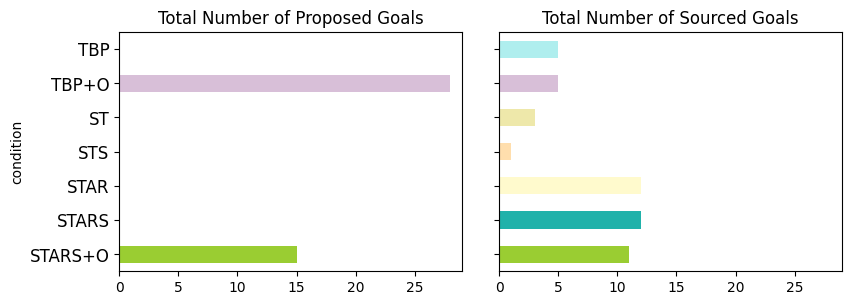

In [685]:
# Alternative quad plot showing proposed/sourced goals and actions
# Actions not relevant to CORL so leaving that out here...
# Must determine max goals

max_goals = int(max(df["proposed goals"])*1.06)
print(max_goals)


save_plot = True
#save_plot = False
plot_title = experiment_name + "_" "LLMStats" + '_'.join(condition_names)

bar_colors = ["lightsteelblue",  "powderblue", "plum", "paleturquoise", "thistle", "palegoldenrod", "navajowhite", "lemonchiffon", "lightseagreen", "yellowgreen"]
bar_colors.reverse()

fig, axes = plt.subplots( nrows=1, ncols=2, sharey=True, sharex=False, figsize=(8,3) )
fig.tight_layout(h_pad=4)
plt.rc('ytick', labelsize=12)

df["proposed goals"].plot(kind="barh", ax=axes[0],title="Total Number of Proposed Goals",color=bar_colors, xlim=[0,max_goals])
#df["proposed actions"].plot(kind="barh", ax=axes[0,1],title="Total Number of Proposed Actions",color=bar_colors, xlim=[0,50])
df["sourced goals"].plot(kind="barh", ax=axes[1], title="Total Number of Sourced Goals",color=bar_colors, xlim=[0,max_goals])
#df["sourced actions"].plot(kind="barh", ax=axes[1,1], title="Total Number of Sourced Actions",color=bar_colors, xlim=[0,50])

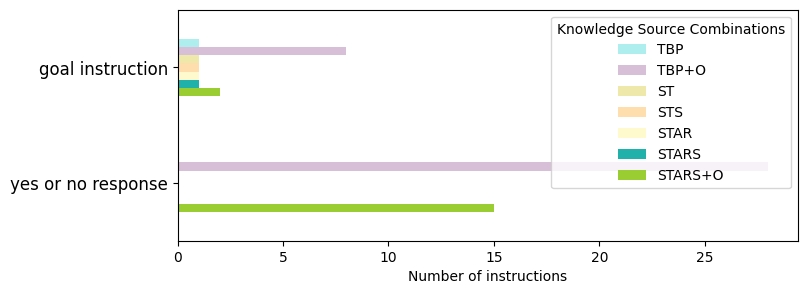

In [686]:
# This is the graphical summary of intructions by type (action, goal, yes/no) by condition
# For CORL paper, not sourcing/using actions so removing them from this plot

save_plot = True
#save_plot = False
plot_title = experiment_name + "_instruction_types" + "_" + '_'.join(condition_names)

# Uncomment if you want to see action instructions 
#ax = df[["yes/no_instructions", "action_instructions", "goal_instructions"]].transpose().plot(kind="barh", color=bar_colors, figsize=(8,3))
ax = df[["yes/no_instructions", "goal_instructions"]].transpose().plot(kind="barh", color=bar_colors, figsize=(8,3))


#plt.xticks(rotation=15, horizontalalignment="center")
#plt.ylabel="Number of instructions"
ax.set_xlabel("Number of instructions")
#ax.set_yticklabels(["yes or no response","action description","goal description"])
ax.set_yticklabels(["yes or no response","goal instruction"])

handles, labels = ax.get_legend_handles_labels()
ax.legend(handles[::-1], labels[::-1], title='Knowledge Source Combinations', loc='upper right')

if (save_plot):
    outfile = output_directory+plot_title+".png"
    ax.figure.savefig(outfile,bbox_inches='tight')



206


/var/folders/th/dv7m537n77d42srhk9ly012h0000gn/T/ipykernel_72290/3748691440.py:47: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  fig.tight_layout(h_pad=4)


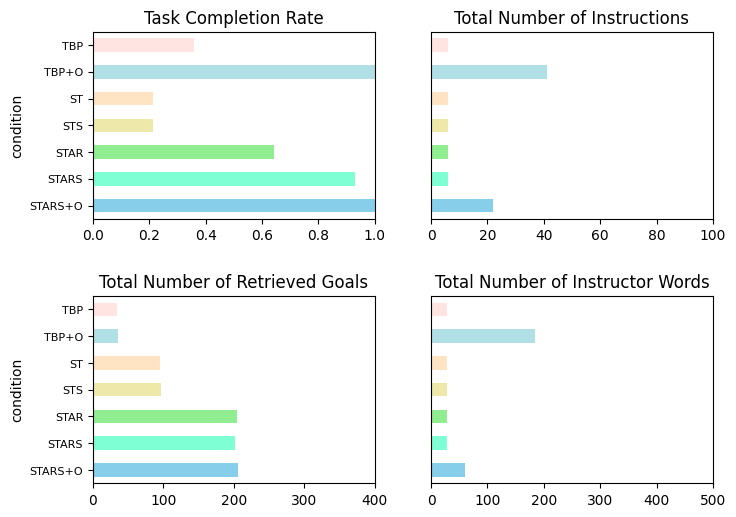

In [687]:
# This is the main summary output file for CORL23. 

save_plot = True
#save_plot = False
plot_title = experiment_name + "summary-matrix_" + '_'.join(condition_names)
plot_title = experiment_name + "summary-matrix" + ''.join(condition_names)


#max_goals = max(max(df["proposed goals"]),max(df["sourced goals"]),max(df["retrieved goals"]))
max_goals = max(df["retrieved goals"])
print(max_goals)
max_goals = int(1.1*max_goals)
if (max_goals < 10):
    max_goals = 10
    
# Again, set by hand so that the axis limits are evident/demarcated
max_words = 500
max_instructions = 100
  
# IF comparing multiple datasets, just set max_goals by hand
max_goals = 400

bar_colors = ["lightsteelblue",  "powderblue", "plum", "paleturquoise", "thistle", "palegoldenrod", "navajowhite", "lemonchiffon", "lightseagreen", "yellowgreen"]
#bar_colors = ["plum", "powderblue", "palegoldenrod", "navajowhite", "yellowgreen"]
bar_colors = ["mistyrose",
              "powderblue",  
              "bisque", "palegoldenrod", "lightgreen", "aquamarine",
              "skyblue"]


human_conditions = ["lm_human","lm_human_tree","lm_human_tree_select","lm_human_tree_eval","lm_human_tree_eval_select"]
human_conditions = ["TBP+O","STARS+O"]
#human_conditions = []
human_conditions = []
human_conditions.reverse()
#human_bar_colors = ["lightsteelblue",  "powderblue", "plum", "paleturquoise", "thistle"]
human_bar_colors = ["powderblue", "skyblue"]

human_bar_colors.reverse()


bar_colors.reverse()

fig, axes = plt.subplots( nrows=3, ncols=2, sharey=False, sharex=False, figsize=(8,8) ,  
                         gridspec_kw={'height_ratios': [3, 3, 1.4],
                                      'hspace': 0.5})
fig.tight_layout(h_pad=4)
plt.rc('ytick', labelsize=12)

df.completion_rate.plot(kind="barh", ax=axes[0,0],title="Task Completion Rate",color=bar_colors,xlim={0,1})
#df.states.plot(kind="barh",ax=axes[1,0],title="Search States",color=bar_colors)
df.instructions.plot(kind="barh", ax=axes[0,1], title="Total Number of Instructions",color=bar_colors,xlim=[0,max_instructions])
df.instructor_words.plot(kind="barh", ax=axes[1,1], title="Total Number of Instructor Words",color=bar_colors,xlim=[0,max_words])
#df["yes/no_instructions"].plot(kind="barh", ax=axes[2,1], title="Total Yes/No Instructions",color=bar_colors)
#df["sourced goals"].plot(kind="barh", ax=axes[1,0], title="Total Number of Sourced Goals",color=bar_colors, xlim=[0,max_goals])
df["retrieved goals"].plot(kind="barh", ax=axes[1,0], title="Total Number of Retrieved Goals",color=bar_colors, xlim=[0,max_goals])


for j in range(3):
    axes[j,1].tick_params(left=False, labelleft=False)
    axes[j,1].set_ylabel(None)
    axes[j,0].tick_params(axis='y', which='major', labelsize=8)

if len(human_conditions) > 0:

    df["proposed goals"][human_conditions].plot(kind="barh", ax=axes[2,0],title="Total # of Goals Presented to User",color=human_bar_colors, xlim=[0,max_goals])
#df["proposed actions"].plot(kind="barh", ax=axes[0,1],title="Total Number of Proposed Actions",color=bar_colors, xlim=[0,50])
#df["sourced actions"].plot(kind="barh", ax=axes[1,1], title="Total Number of Sourced Actions",color=bar_colors, xlim=[0,50])
    df.relevant_responses[human_conditions].plot(kind="barh", ax=axes[2,1],title="Fraction of Accepted Yes/No Responses",color=human_bar_colors, xlim={0,1})
    axes[2,0].set_yticklabels(human_conditions)
    
else:
    # IF there are no human conditions, remove the human-only data from the overall figure
    axes[2,0].remove()
    axes[2,1].remove()




if (save_plot):
    outfile = output_directory+plot_title+".png"
    fig.savefig(outfile,bbox_inches='tight')


#plt.subplots_adjust()
#plt.show()



OfficeTask
Fraction of Accepted Yes/No Responses:


/var/folders/th/dv7m537n77d42srhk9ly012h0000gn/T/ipykernel_72290/1779828595.py:53: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  fig.tight_layout(h_pad=4)


condition
STARS+O    0.733333
TBP+O      0.178571
Name: relevant_responses, dtype: float64

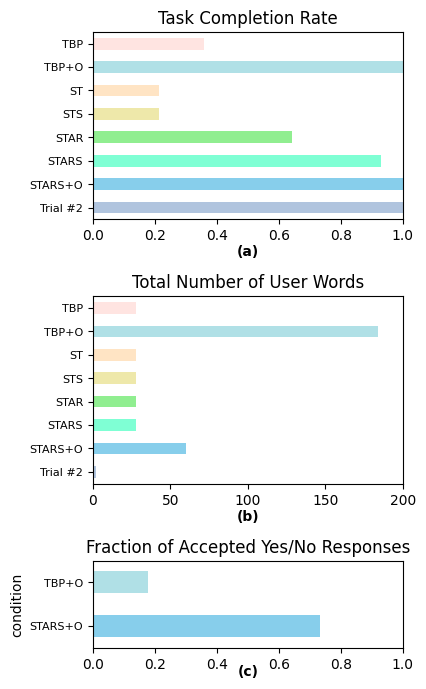

In [688]:
# This is the reduced summary output file for CORL23 (body of paper version)

save_plot = True
#save_plot = False
plot_title = experiment_name + "TaskCompletionUserWordsFractionYesNoSummary" + ''.join(condition_names)

#max_goals = max(max(df["proposed goals"]),max(df["sourced goals"]),max(df["retrieved goals"]))
max_goals = max(df["retrieved goals"])
# print(max_goals)
max_goals = int(1.1*max_goals)
if (max_goals < 10):
    max_goals = 10

print(experiment_name)
# Again, set by hand so that the axis limits are evident/demarcated
if experiment_name == "GroceryTask":
    max_words = 100
elif experiment_name == "TidyKitchenTask":
    max_words = 450
elif experiment_name == "OfficeTask":
    max_words = 200
else:
    raise ValueError("Unknown experiment name: " + experiment_name)
max_instructions = 100
  
# IF comparing multiple datasets, just set max_goals by hand
max_goals = 400

# bar_colors = ["lightsteelblue",  "powderblue", "plum", "paleturquoise", "thistle", "palegoldenrod", "navajowhite", "lemonchiffon", "lightseagreen", "yellowgreen"]
#bar_colors = ["plum", "powderblue", "palegoldenrod", "navajowhite", "yellowgreen"]
bar_colors = ["mistyrose",
              "powderblue",  
              "bisque", "palegoldenrod", "lightgreen", "aquamarine",
              "skyblue", "lightsteelblue"]


human_conditions = ["lm_human","lm_human_tree","lm_human_tree_select","lm_human_tree_eval","lm_human_tree_eval_select"]
human_conditions = ["TBP+O","STARS+O"]
# human_conditions = []
#human_conditions = []
human_conditions.reverse()
#human_bar_colors = ["lightsteelblue",  "powderblue", "plum", "paleturquoise", "thistle"]
human_bar_colors = ["powderblue", "skyblue"]

human_bar_colors.reverse()


bar_colors.reverse()

fig, axes = plt.subplots( nrows=3, ncols=1, sharey=False, sharex=False, figsize=(4,8) ,  
                         gridspec_kw={'height_ratios': [3, 3, 1.4],
                                      'hspace': 0.5})
fig.tight_layout(h_pad=4)
plt.rc('ytick', labelsize=12)

# Add post-learning condition manually at the bottom of each plot (no raw data for this)
completion_rate = pd.concat([pd.Series({"Trial #2": 1.0}), df.completion_rate.copy()])
instructor_words = pd.concat([pd.Series({"Trial #2": 2}), df.instructor_words.copy()])

completion_rate.plot(kind="barh", ax=axes[0],title="Task Completion Rate",color=bar_colors,xlim={0,1})
#df.states.plot(kind="barh",ax=axes[1,0],title="Search States",color=bar_colors)
#df.instructions.plot(kind="barh", ax=axes[0,1], title="Total Number of Instructions",color=bar_colors,xlim=[0,max_instructions])
instructor_words.plot(kind="barh", ax=axes[1], title="Total Number of User Words",color=bar_colors,xlim=[0,max_words])
#df["yes/no_instructions"].plot(kind="barh", ax=axes[2,1], title="Total Yes/No Instructions",color=bar_colors)
#df["sourced goals"].plot(kind="barh", ax=axes[1,0], title="Total Number of Sourced Goals",color=bar_colors, xlim=[0,max_goals])
#df["retrieved goals"].plot(kind="barh", ax=axes[1,0], title="Total Number of Retrieved Goals",color=bar_colors, xlim=[0,max_goals])

for j in range(3):
#    axes[j,1].tick_params(left=False, labelleft=False)
#    axes[j,1].set_ylabel(None)
    axes[j].tick_params(axis='y', which='major', labelsize=8)
    label = "(" + chr(ord('a') + j) + ")"  # Generate label "(a)", "(b)", "(c)"
    if j < 2:
        offset = 0
    else:
        offset = -.1
    axes[j].text(0.5, -.175+offset, label, transform=axes[j].transAxes,
            fontsize=10, fontweight='bold', va='center', ha='center')


if len(human_conditions) > 0:

#    df["proposed goals"][human_conditions].plot(kind="barh", ax=axes[2,0],title="Total # of Goals Presented to User",color=human_bar_colors, xlim=[0,max_goals])
#df["proposed actions"].plot(kind="barh", ax=axes[0,1],title="Total Number of Proposed Actions",color=bar_colors, xlim=[0,50])
#df["sourced actions"].plot(kind="barh", ax=axes[1,1], title="Total Number of Sourced Actions",color=bar_colors, xlim=[0,50])
    df.relevant_responses[human_conditions].plot(kind="barh", ax=axes[2],title="Fraction of Accepted Yes/No Responses",color=human_bar_colors, xlim={0,1})
    axes[2].set_yticklabels(human_conditions)
    print("Fraction of Accepted Yes/No Responses:")
    with open(output_directory+"fraction_yes_no"+".txt", "w") as f:
        display(df.relevant_responses[human_conditions])
        df.relevant_responses[human_conditions].to_csv(f, sep="\t")
    
else:
    # IF there are no human conditions, remove the human-only data from the overall figure
    axes[2].remove()
    
    
if (save_plot):
    outfile = output_directory+plot_title+".png"
    fig.savefig(outfile,bbox_inches='tight')


#plt.subplots_adjust()
#plt.show()



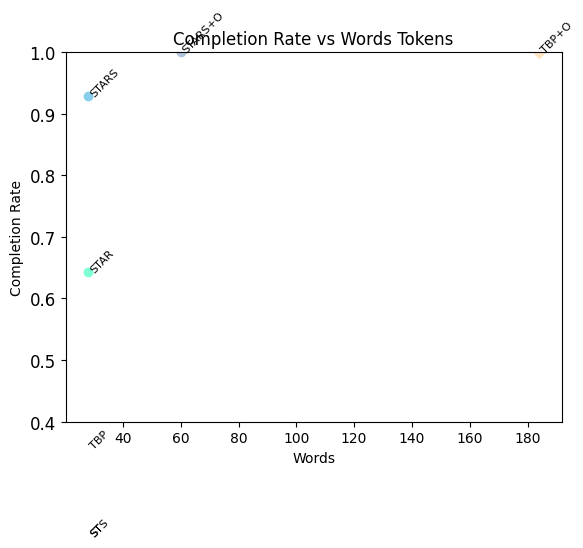

In [689]:
# Extract data from the data frame
conditions = df.index
tokens = df['total tokens']
words = df['instructor_words']
completion_rate = df['completion_rate']

point_types = ['o', 'D', 's', 'v', '^']

# Create scatter plot
for i in range(len(tokens)):
    plt.scatter(words[i], completion_rate[i],color=bar_colors[i],marker=point_types[int(i/5)])

# Add labels to the data points
for i, condition in enumerate(conditions):
    plt.text(words[i], completion_rate[i], condition,fontsize=8,rotation=45)

# Set plot title and axis labels
plt.title('Completion Rate vs Words Tokens')
plt.xlabel('Words')
plt.ylabel('Completion Rate')
#plt.xlim(3,6)
plt.ylim(.4,1)

# Show the plot
plt.show()


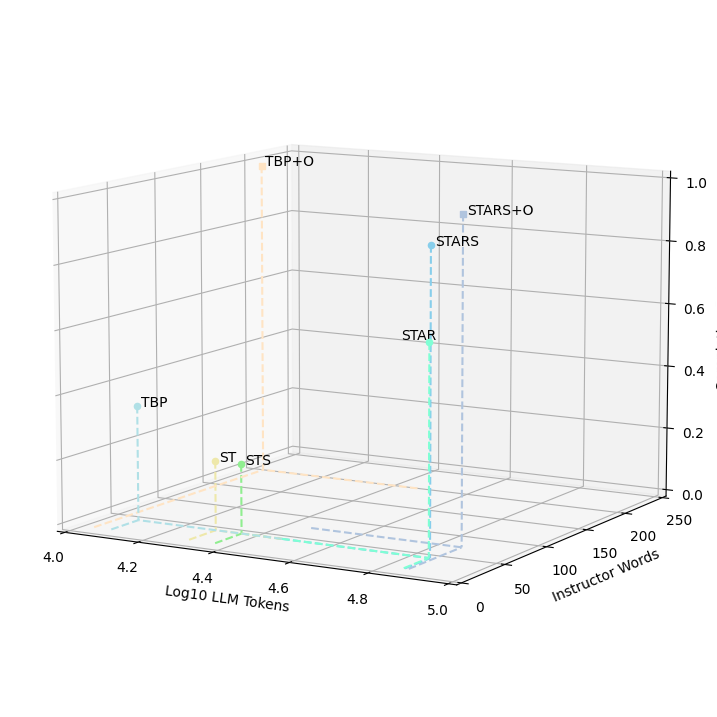

In [690]:
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

saveplot=True
#saveplot=False

#plot_title = experiment_name + "_completion_vs_tokens_vs_words" + '_'.join(condition_names)
plot_title = experiment_name + "CompletionvsTokensvsWords" + ''.join(condition_names)


# Extract data from the data frame
conditions = df.index
tokens = np.log10(df['total tokens'])
completion_rate = df['completion_rate']
words = df['instructor_words']

# Create 3D scatter plot
fig = plt.figure(figsize=(9,16))
ax = fig.add_subplot(111, projection='3d')

# Create scatter plot
for i in range(len(tokens)):
    if conditions[i] in human_conditions:
        point_type = point_types[2]
    else:
        point_type = point_types[0]
    ax.scatter(tokens[i], words[i], completion_rate[i],color=bar_colors[i],marker=point_type)

# Add labels to the data points
for i, condition in enumerate(conditions):
    x_offset = .01
    y_offset = 0
    if condition == "STAR":
        x_offset = -.07
    elif condition == "STARS":
        y_offset = .05
    ax.text(tokens[i]+x_offset, words[i]+y_offset, completion_rate[i], condition, rotation=45)

# Set plot title and axis labels
#ax.set_title('Completion Rate vs. Tokens vs. Words'+': '+experiment_name)

ax.set_xlabel('Log10 LLM Tokens')
ax.set_ylabel('Instructor Words')
ax.set_zlabel('Completion Rate')

# Set axis limits
if experiment_name == "TidyKitchenTask":
    ax.set_xlim3d(4.5, 5.2)
    ax.set_ylim3d(0, 600)
if experiment_name == "GroceryTask":
    ax.set_xlim3d(4.2, 4.9)
    ax.set_ylim3d(0, 100)
if experiment_name == "OfficeTask":
    ax.set_ylim3d(0, 250)
    ax.set_xlim3d(4, 5)

ax.set_zlim3d(0, 1)

for i in range(len(tokens)):
    ax.plot([tokens[i], tokens[i]], [0, words[i]], [0, 0], color=bar_colors[i], linestyle='dashed')  # Projection onto x-axis
    ax.plot([4.5,tokens[i]], [words[i], words[i]], [0, 0], color=bar_colors[i], linestyle='dashed')  # Projection onto y-axis
    ax.plot([tokens[i], tokens[i]], [words[i], words[i]], [completion_rate[i], 0], color=bar_colors[i], linestyle='dashed')  # Projection onto z-axis

ax.view_init(elev=10, azim=-60)

if (save_plot):
    outfile = output_directory+plot_title+".png"
    fig.savefig(outfile,bbox_inches='tight')

# Show the plot
plt.show()


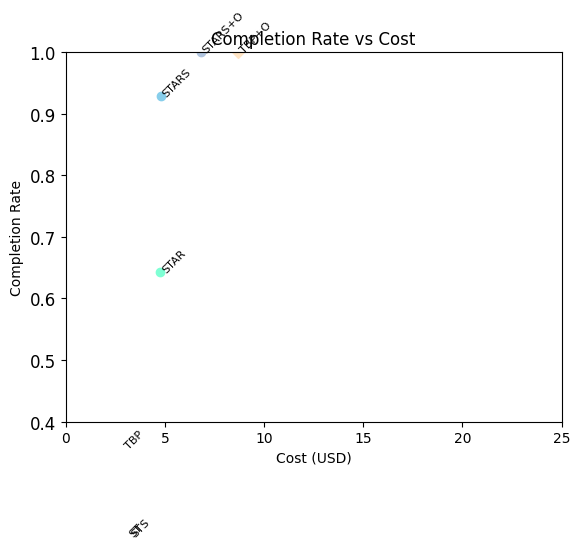

In [691]:
token_cost = .00003
human_cost_per_hr = 25 
hr_per_yesno = 15/3600
hr_per_complex_instruction = 60/3600

# Extract data from the data frame
conditions = df.index
tokens = df['total tokens']
words = df['instructor_words']
yesno_words = df['yes/no_instructions']
complex_words = words - yesno_words
completion_rate = df['completion_rate']
instructions = df['instructions']
complex_instructions = instructions - yesno_words

cost = tokens*token_cost + human_cost_per_hr * (yesno_words*hr_per_yesno + complex_instructions*hr_per_complex_instruction)

point_types = ['o', 'D', 's', 'v', '^']

# Create scatter plot
for i in range(len(tokens)):
    plt.scatter(cost[i], completion_rate[i],color=bar_colors[i],marker=point_types[int(i/5)])

# Add labels to the data points
for i, condition in enumerate(conditions):
    plt.text(cost[i], completion_rate[i], condition,fontsize=8,rotation=45)

# Set plot title and axis labels
plt.title('Completion Rate vs Cost')
plt.xlabel('Cost (USD)')
plt.ylabel('Completion Rate')
plt.xlim(0,25)
plt.ylim(.4,1)

# Show the plot
plt.show()
